# Churn Prediction
Customer churn refers to the phenomenon where customers discontinue their relationship or subscription with a company or service provider. It represents the rate at which customers stop using a company's products or services within a specific period. Churn is an important metric for businesses as it directly impacts revenue, growth, and customer retention.

In the context of the Churn dataset, the churn label indicates whether a customer has churned or not. A churned customer is one who has decided to discontinue their subscription or usage of the company's services. On the other hand, a non-churned customer is one who continues to remain engaged and retains their relationship with the company.

Understanding customer churn is crucial for businesses to identify patterns, factors, and indicators that contribute to customer attrition. By analyzing churn behavior and its associated features, companies can develop strategies to retain existing customers, improve customer satisfaction, and reduce customer turnover. Predictive modeling techniques can also be applied to forecast and proactively address potential churn, enabling companies to take proactive measures to retain at-risk customers.

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Set directory
os.chdir(r'D:\Fabian\Github\ChurnSeg-Insight')

# 1. Data Loading and Understanding

In [11]:
# Set directory and load file
rel_path = r'data\customer_churn_dataset-testing-master.csv'
df = pd.read_csv(rel_path)

# Descripe data
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


(         CustomerID           Age        Tenure  Usage Frequency  \
 count  64374.000000  64374.000000  64374.000000     64374.000000   
 mean   32187.500000     41.970982     31.994827        15.080234   
 std    18583.317451     13.924911     17.098234         8.816470   
 min        1.000000     18.000000      1.000000         1.000000   
 25%    16094.250000     30.000000     18.000000         7.000000   
 50%    32187.500000     42.000000     33.000000        15.000000   
 75%    48280.750000     54.000000     47.000000        23.000000   
 max    64374.000000     65.000000     60.000000        30.000000   
 
        Support Calls  Payment Delay   Total Spend  Last Interaction  \
 count   64374.000000   64374.000000  64374.000000      64374.000000   
 mean        5.400690      17.133952    541.023379         15.498850   
 std         3.114005       8.852211    260.874809          8.638436   
 min         0.000000       0.000000    100.000000          1.000000   
 25%         3.00

In [12]:
# Grouping columns. This makes it easy to call later
numerical_columns = ['Age', 'Tenure', 'Usage Frequency','Support Calls', 'Payment Delay', 'Contract Length', 'Total Spend', 'Last Interaction'] 
categorical_columns = ['Subscription Type', 'Gender', 'Contract Length']
target_column = ['Churn']


In [13]:
# No duplicates. There are no duplicates by customerID. We can also add more column sto check for duplicates. 
df.loc[df.duplicated(subset=['CustomerID'])]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


# 2. Feature engineering
We do this to help the model capture non-linear relationships and add context beyond raw values.

In [14]:
# 1. Ratio of engagement for each user
df['Engagement ratio'] = df['Usage Frequency']/df['Tenure']

# 2. What is the agegroup of users
df['Age groups'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65, 75], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66-75'])

# 3. Tenure - New Customer Flag and Binning
df['New_Customer'] = np.where(df['Tenure'] < 6, 1, 0)
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=[0, 6, 12, 24, 36, 100], labels=['<6m', '6-12m', '12-24m', '24-36m', '36m+'])

# 4. Usage Frequency - Create Usage per Month
df['Usage_per_Month'] = df['Usage Frequency'] / (df['Tenure'])  # Add 1 to avoid division by zero

# 5. Support Calls - Frequent Caller Flag
df['Frequent_Caller'] = np.where(df['Support Calls'] > 3, 1, 0)

# 6. Payment Delay - Payment Issues Flag
df['Payment_Issue'] = np.where(df['Payment Delay'] > 0, 1, 0)

# 7. When was the last interaction
reference_date = df['Last Interaction'].max()  # Or use a fixed date if needed
df['Days_Since_Interaction'] = (reference_date - df['Last Interaction'])

# 8. Recent Interaction Flag (e.g., interacted within last 30 days)
df['Recent_Interaction'] = np.where(df['Days_Since_Interaction'] <= 30, 1, 0)


In [15]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn',
       'Engagement ratio', 'Age groups', 'New_Customer', 'Tenure_Group',
       'Usage_per_Month', 'Frequent_Caller', 'Payment_Issue',
       'Days_Since_Interaction', 'Recent_Interaction'],
      dtype='object')

## 2b. Choice of encoder to use

Ordinal encoder

- Contract length: There's a clear order based on commitment duration. The model can benefit from understanding that Annual > Quarterly > Monthly.

- Subscription type: There's an implied order in subscription tiers, so the model benefits from knowing this hierarchy. (Basic < Standard < Premium in terms of features or price)

Label encoding or Manual 0/1 mapping

- Gender: One-Hot Encoding would unnecessarily create two columns with redundant information. This is simple, interpretable, and efficient.

In [16]:
df['Contract Length'] = df['Contract Length'].map({
    'Monthly': 0,
    'Quarterly': 1,
    'Annual': 2
})

df['Subscription Type'] = df['Subscription Type'].map({
    'Basic': 0,
    'Standard': 1,
    'Premium': 2
})

df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

df = pd.get_dummies(df, columns=['Tenure_Group', 'Age groups'], drop_first=True)

## 2c. Class imbalance
Our class distribution is roughly balanced hence we do not need to rebalance. Our current class distribution is Acceptable (52.6% vs. 47.4%).  
if the case was like;
- 90% vs. 10% → Severe imbalance
- 70% vs. 30% → Moderate imbalance
- 52.6% vs. 47.4% → Acceptable, no imbalance concern

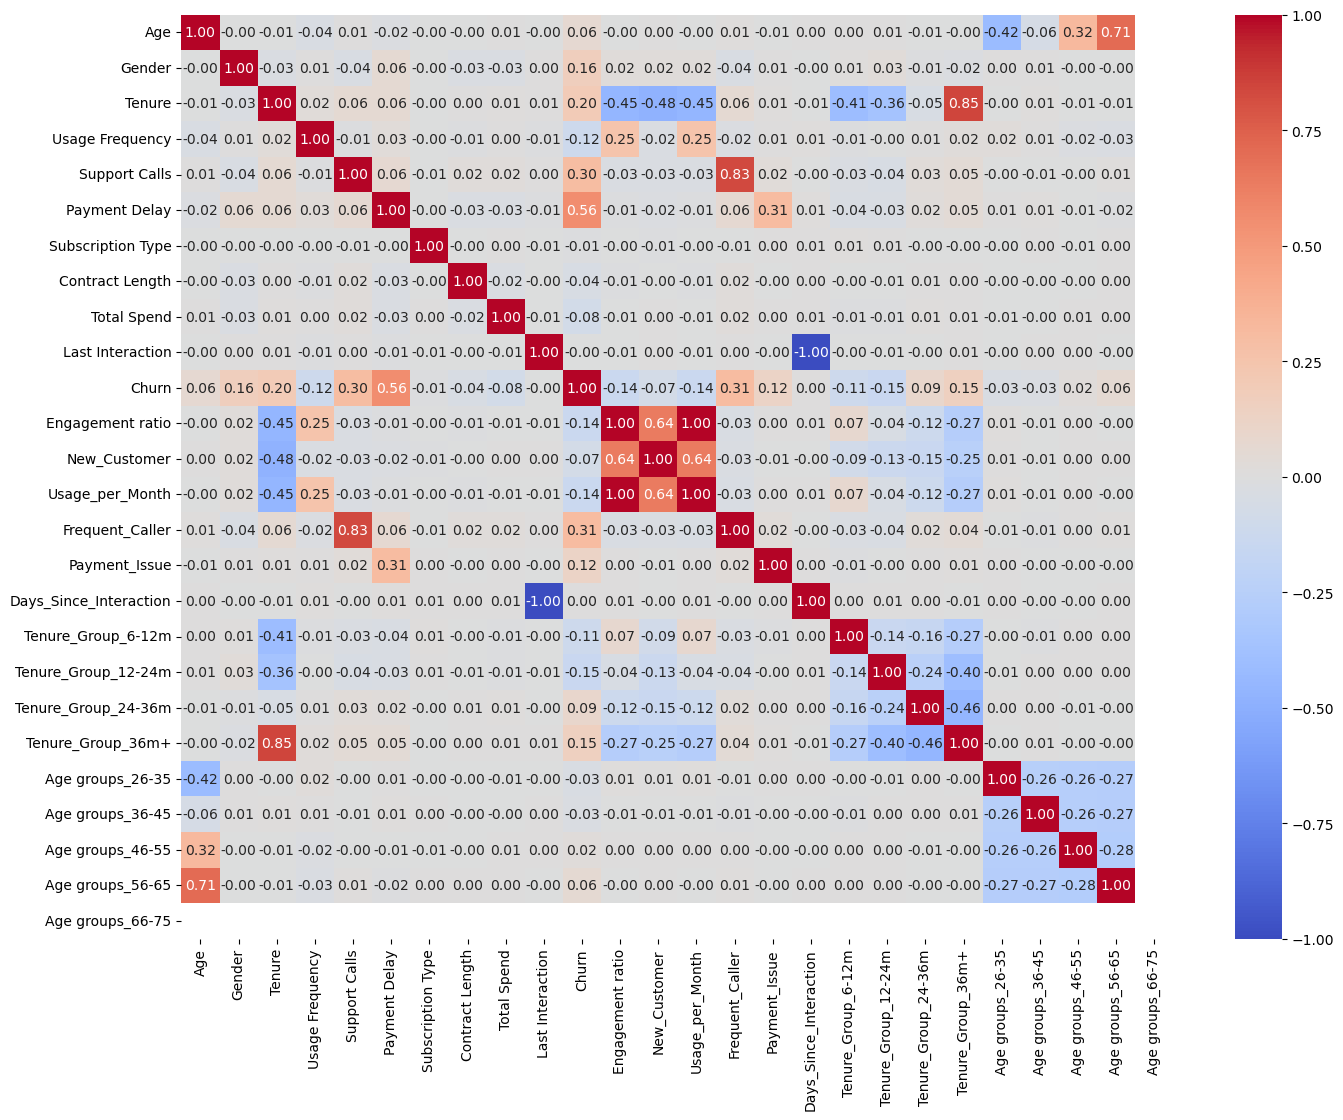

In [17]:
corr_df = df.drop(columns=['Recent_Interaction', 'CustomerID']).corr()
plt.figure(figsize=(16, 12))  # Adjust as needed
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


- Payment delay: 0.56 - Strong postive correlation. Payment delay shows that it can strongly increase churn likelihood.  
- Frequent_Caller: 0.31 — Positive correlation. Customers who call frequently may be more likely to churn, possibly due to dissatisfaction.
- Support calls: 0.3 - Positive correlation. Customers who are dissatisfied tend to call alot leading to a high churn likelihood. 


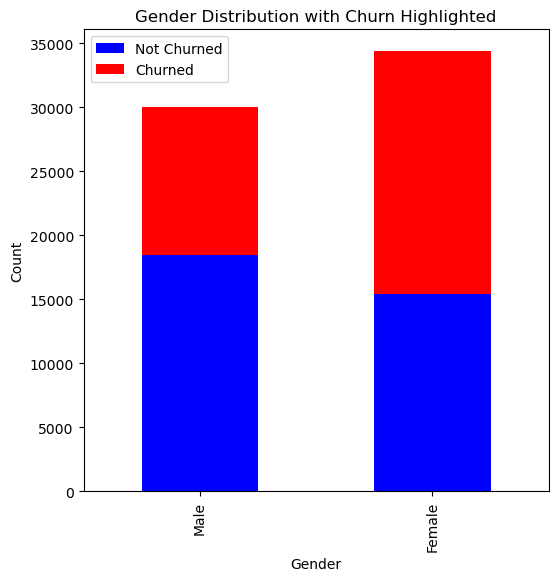

In [18]:
# Group by Gender and Churn
gender_churn_counts = df.groupby(['Gender', 'Churn']).size().unstack(fill_value=0)

# Rename index for clarity (optional)
gender_churn_counts.index = ['Male', 'Female']

# Stacked bar plot
gender_churn_counts.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(6, 6))

plt.title('Gender Distribution with Churn Highlighted')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(['Not Churned', 'Churned'])
plt.show()


In [19]:
gender_churn_counts

Churn,0,1
Male,18439,11582
Female,15442,18911


Our data contains more females than males. More females seem to have churned more relative to males. 

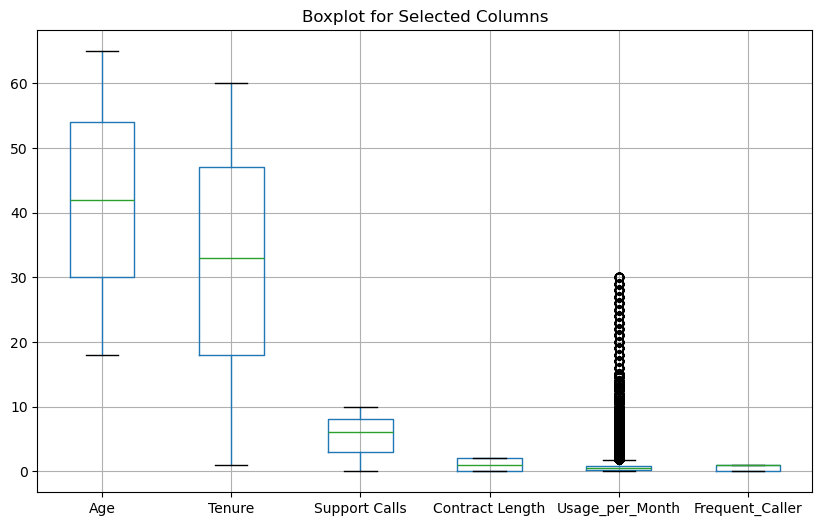

In [20]:
boxplot_df = df.drop(columns=['Recent_Interaction', 'CustomerID'])
# Select specific columns to plot
columns_to_plot = ['Age', 'Tenure', 'Support Calls', 'Contract Length', 'Usage_per_Month', 'Frequent_Caller']

# Plot boxplot for selected columns
boxplot_df[columns_to_plot].boxplot(figsize=(10, 6))
plt.title('Boxplot for Selected Columns')
plt.show()

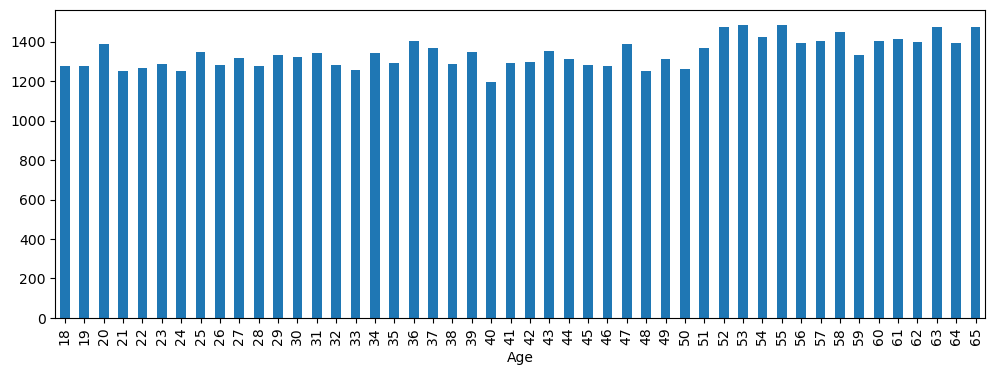

In [21]:
df['Age'].value_counts().sort_index().plot(kind='bar', figsize=(12, 4))
plt.show()


This is a fairly balanced dataset. 

# 3. Feature selection
We know which feature to look forward to as predictors. 

In [22]:
# These are our predictors. We do not use CustomerID as we don not need an identifier for each row. 

features = ['Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction',
       'Engagement ratio', 'New_Customer', 'Usage_per_Month',
       'Frequent_Caller', 'Payment_Issue', 'Days_Since_Interaction',
       'Recent_Interaction', 'Tenure_Group_6-12m', 'Tenure_Group_12-24m',
       'Tenure_Group_24-36m', 'Tenure_Group_36m+', 'Age groups_26-35',
       'Age groups_36-45', 'Age groups_46-55', 'Age groups_56-65',
       'Age groups_66-75']
target = ['Churn']

X = df[features]
y = df[target]

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
# We use this to ensure all features are on similar scale, improing the performance of the model and sometimes avoids bias. 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Model
For the sake of this exercise, we will look at multiple classification methods and compare at the end. 
## 4a Random Forest Classifier

In [23]:
# First model: RandomForest Classifier
# n_estimators: Determines the number of decision trees in the model, it improves the performance by reducing variance but can increase computation cost , reducing it may cost higher variance and less computation power.  
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

c:\Users\Asus\anaconda3\envs\ad_content\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
y_pred = model.predict(X_test)

# 5.  Results
Here we use confusion matrix, classification report and accuracy report.

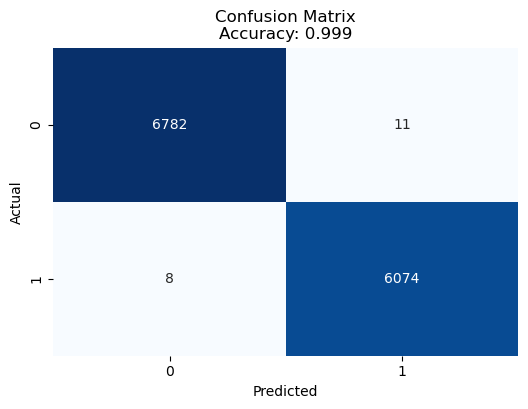

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- True Negatives (TN = 6782): Correctly predicted class 0 (No Churn).

- False Positives (FP = 11): Predicted 1 (Churn) but actual was 0.

- False Negatives (FN = 9): Predicted 0 (No Churn) but actual was 1.

- True Positives (TP = 6073): Correctly predicted class 1 (Churn).

In [26]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875



In [27]:
print(accuracy)

0.9985242718446602


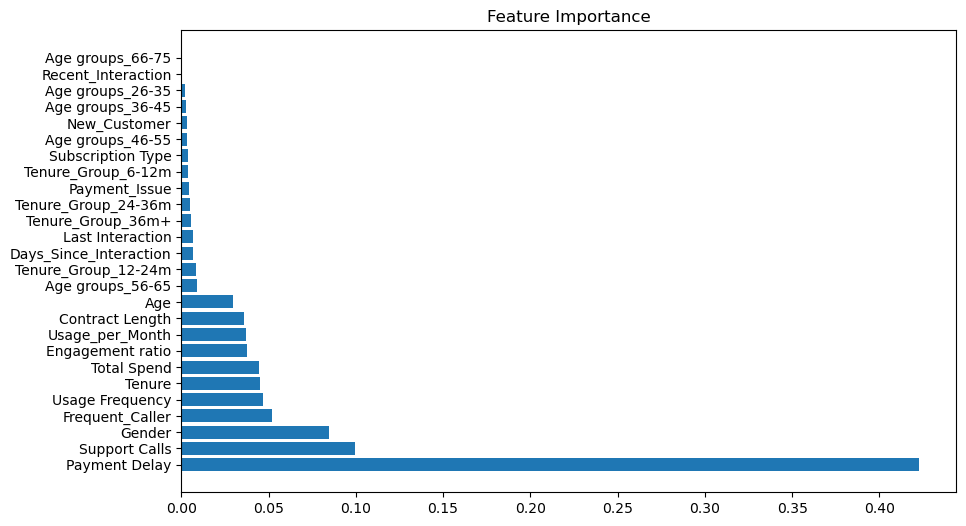

In [28]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.show()

## 4a': Decision tree

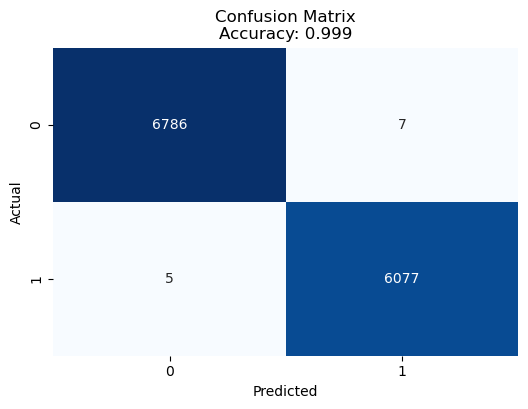

In [31]:
# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier()
# Train the model
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875



In [33]:
print(accuracy)

0.9990679611650486


## 4b Logistic regression
We go back to point 4, to run other models. 

In [28]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(conf_matrix_log_reg, class_report_log_reg, accuracy_log_reg)

[[5754 1039]
 [ 933 5149]]               precision    recall  f1-score   support

           0       0.86      0.85      0.85      6793
           1       0.83      0.85      0.84      6082

    accuracy                           0.85     12875
   macro avg       0.85      0.85      0.85     12875
weighted avg       0.85      0.85      0.85     12875
 0.8468349514563107


c:\Users\Asus\anaconda3\envs\topic_modelling\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 4c. SVM

In [29]:
# Build and train the SVM  odel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(conf_matrix_svm, class_report_svm, accuracy_svm)

c:\Users\Asus\anaconda3\envs\topic_modelling\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[5779 1014]
 [ 933 5149]]               precision    recall  f1-score   support

           0       0.86      0.85      0.86      6793
           1       0.84      0.85      0.84      6082

    accuracy                           0.85     12875
   macro avg       0.85      0.85      0.85     12875
weighted avg       0.85      0.85      0.85     12875
 0.8487766990291262


## 4d. KNN

In [30]:
# Build and train the SVM  odel
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate model
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(conf_matrix_knn, class_report_knn, accuracy_knn)

c:\Users\Asus\anaconda3\envs\topic_modelling\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[5935  858]
 [ 459 5623]]               precision    recall  f1-score   support

           0       0.93      0.87      0.90      6793
           1       0.87      0.92      0.90      6082

    accuracy                           0.90     12875
   macro avg       0.90      0.90      0.90     12875
weighted avg       0.90      0.90      0.90     12875
 0.8977087378640777


## 4e. Gradient booosting classifier

In [31]:
# Build and train the SVM  odel
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate model
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
class_report_gbm = classification_report(y_test, y_pred_gbm)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)

print(conf_matrix_gbm, class_report_gbm, accuracy_gbm)

c:\Users\Asus\anaconda3\envs\topic_modelling\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[6788    5]
 [  21 6061]]               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875
 0.9979805825242718


# 6. Comparison

In [32]:
# Create a dataframe with accuracy results
Final_result = pd.DataFrame({
    'GBM Accuracy': [accuracy_gbm],
    'KNN Accuracy': [accuracy_knn],
    'SVM Accuracy': [accuracy_svm],
    'LogReg Accuracy': [accuracy_log_reg],
    'RandomForest Classifier Accuracy': [accuracy]
})

In [33]:
Final_result

,GBM Accuracy,KNN Accuracy,SVM Accuracy,LogReg Accuracy,RandomForest Classifier Accuracy
0,0.997981,0.897709,0.848777,0.846835,0.998447
